In [1]:
import pandas as pd
import numpy as np
import os
import h5py
from tqdm import tqdm

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
%matplotlib inline

# from skimage.transform import imresize
from itertools import chain
from sklearn.metrics import accuracy_score, recall_score, precision_score

from scipy.misc import imresize
import torch
import torchvision
import itertools
from tqdm import tqdm
import logging
import warnings
warnings.filterwarnings('ignore')

from torch.nn import Sigmoid
from torch import Tensor, LongTensor
from torch.autograd import Variable
import torch.nn as nn
import torch
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.models.detection.image_list import ImageList 

from PIL import Image

from birad import createBMIDataset
from birad import *

logging.basicConfig(format='%(message)s',level = logging.INFO)

inputFolder1 = '/home/santhosr/Documents/Birad/ProcessedData/FullRes'
truthFile1 = '/home/santhosr/Documents/Birad/birad_targetFile.csv'

inputFolder2 = '/home/santhosr/Documents/Birad/ProcessedData/PennExtra_3500/'
truthFile2 = '/home/santhosr/Documents/Birad/RaceDL_ExtraCaucasian.csv'

df1 = pd.read_csv('/home/santhosr/Documents/Birad/birad_targetFile.csv')
df1.drop(['PresIntentType','DBT'],inplace = True,axis=1)


df2 = pd.read_csv('/home/santhosr/Documents/Birad/RaceDL_ExtraCaucasian.csv')
df2.Medview_Race = 'White'
truth = pd.concat([df1,df2],sort=True)

import sys

from torchvision import transforms

# sys.path.insert(0, '/home/santhosr/Documents/Birad/FastAI/utils.py' )
sys.path.insert(0,'/home/santhosr/Documents/Birad/PyTorch/')

from utils import *

In [2]:
logData = True

setTruthFile(truth)

In [3]:
class Dataset(torch.utils.data.Dataset):
  def __init__(self, dataList):
    
    
    self.data = dataList


    
  def __len__(self):
    
    return len(self.data)
    
  def __getitem__(self, index):
    
    filename = self.data.iloc[index].filename.split("/")[-1]
    
    data = getImageData(filename)
    
    data = Image.fromarray(data)
    
    tfsm = transforms.Compose([transforms.Resize([256,256]),
                             transforms.ToTensor(),
                             transforms.Normalize(mean = [0.7601], std = [0.3307])])
    
    
    data = tfsm(data)
    
#     data = Image.fromarray(data)
#     data = data.resize(imgSize)
#     data = np.array(data)
#     data = data/256.0 
    
#     data = torchvision.transforms.ToTensor()(data)
    
#     data = data.float()
    
    
    
    data = data.repeat((3,1,1))
    
#     data = torchvision.transforms.Normalize(mean = [0.7601, 0.7601, 0.7601], std = [0.3307, 0.3307, 0.3307])(data)
    
    
    
#     mean = torch.Tensor([0.7601, 0.7601, 0.7601]).to('cuda')
#     std = torch.Tensor([0.3307, 0.3307, 0.3307]).to('cuda')
#     data = torchvision.transforms.Normalize(mean = mean, std = std)(data)
    
    
    label = getRaceLabel(filename)
    
    return data,label

### Testing pretrained FASTAI model

In [4]:
class fastAIModel(nn.Module):
    def __init__(self):
        super(fastAIModel, self).__init__()
        
    
        self.body =  Sequential(*list(resnet50().children())[:-2])
    
        
        self.head =     Sequential(
                            AdaptiveConcatPool2d(), Flatten(),
                            nn.BatchNorm1d(4096, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), 
                            nn.Dropout(p=0.25), 
                            nn.Linear(in_features=4096, out_features=512, bias=True), 
                            nn.ReLU(inplace = True),
                            nn.BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), 
                            nn.Dropout(p=0.5), 
                            nn.Linear(in_features=512, out_features=2, bias=True)
                        )
        
        
        self.total = nn.Sequential(self.body, self.head)
    
        
    def forward(self, x):
        
        
        x = self.total(x)
        

        return x
    
    
def test(model, dataset, num_batches = 10,test_batch_size=30, returnPreds = []):
    
    testPreds = []
    testOutputs = []
    
    testLoader = torch.utils.data.DataLoader( dataset,
            batch_size = test_batch_size, shuffle = False)

    criterion = torch.nn.CrossEntropyLoss()
    
    device ='cuda'

    val_losses = 0
    val_batches = 0
    total = 0
    correct = 0
    precision, recall, f1, accuracy = [], [], [], []

    model.eval()
    with torch.no_grad():
        for i, (data,target) in enumerate(testLoader):
        
            data,target = data.to(device), target.to(device)

            data = data.float()

           
            output = model(data) 
            
            output = nn.Softmax()(output)
            
            testOutputs.append(output.cpu().numpy())
            
            val_losses += criterion(output, target)
            val_batches += 1

            pred = torch.max(output, 1)[1] # get class from network's prediction
            
            testPreds.append(pred.cpu().numpy())
            
            total += target.size(0)
            correct += (pred == target).sum().item()
            
            if i==num_batches:
                break
    
    acc = correct/float(total)
    
    print("Epoch {}, val loss : {}, val acc : {}".format(1, val_losses/val_batches , np.round(acc,3) ))

    if returnPreds:
        return val_losses/val_batches, acc, testPreds, testOutputs
    else:
        return val_losses/val_batches, acc
    

In [5]:
model = fastAIModel()

In [6]:
model.total.load_state_dict(torch.load('/home/santhosr/Documents/Birad/ProcessedData/models/model_resnet50_id10_acc833_loss386.pth')['model'])

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [90]:
df = pd.read_csv('/home/santhosr/Documents/Birad/FastAI/RaceClassification/withLargerDataset/DataFile10.csv')

trainDf = df[df.train==False]
testDf = df[df.train==True]

In [91]:
trainData = Dataset(trainDf)
testData = Dataset(testDf)



In [8]:
t = torch.ones((1,3,224,224))

model.to('cuda')

model.eval()

model(t.cuda())

tensor([[-0.0685,  0.5951]], device='cuda:0', grad_fn=<AddmmBackward>)

In [ ]:
-0.0685,  0.5951

In [92]:
# imgSize = (256,256)
# device = 'cuda'

# model.to(device)

# test_batch_size = 100
# test(model, testData, num_batches=50)

In [93]:
model.to(device)
pred = test(model, testData, num_batches=1, returnPreds=True)

torch.Size([3, 256, 256])
torch.Size([3, 256, 256])
torch.Size([3, 256, 256])
torch.Size([3, 256, 256])
torch.Size([3, 256, 256])
torch.Size([3, 256, 256])
torch.Size([3, 256, 256])
torch.Size([3, 256, 256])
torch.Size([3, 256, 256])
torch.Size([3, 256, 256])
torch.Size([3, 256, 256])
torch.Size([3, 256, 256])
torch.Size([3, 256, 256])
torch.Size([3, 256, 256])
torch.Size([3, 256, 256])
torch.Size([3, 256, 256])
torch.Size([3, 256, 256])
torch.Size([3, 256, 256])
torch.Size([3, 256, 256])
torch.Size([3, 256, 256])
torch.Size([3, 256, 256])
torch.Size([3, 256, 256])
torch.Size([3, 256, 256])
torch.Size([3, 256, 256])
torch.Size([3, 256, 256])
torch.Size([3, 256, 256])
torch.Size([3, 256, 256])
torch.Size([3, 256, 256])
torch.Size([3, 256, 256])
torch.Size([3, 256, 256])
torch.Size([3, 256, 256])
torch.Size([3, 256, 256])
torch.Size([3, 256, 256])
torch.Size([3, 256, 256])
torch.Size([3, 256, 256])
torch.Size([3, 256, 256])
torch.Size([3, 256, 256])
torch.Size([3, 256, 256])
torch.Size([

In [96]:
testSub = testDf.iloc[:len(np.concatenate(pred[2]))]

testSub['imageName'] = testSub.filename.apply(lambda x : x.split("/")[-1].split(".")[0])



predDf = pd.read_csv('/home/santhosr/Documents/Birad/FastAI/RaceClassification/withLargerDataset/model10_1_Predictions.csv')

testSub = testSub.merge(predDf[['imageName','predLabel','truthLabel','score0','score1']], on='imageName',how ='left')

testSub.drop(['DummyID','train','filename'],inplace = True, axis = 1)

testSub_ = pd.DataFrame({'imageName' : testSub.iloc[:len(np.concatenate(pred[2]))]['imageName'] , 
                         'predLabel_' : np.concatenate(pred[2]),
                         "score0_": np.concatenate(pred[3])[:,0],
                         "score1_": np.concatenate(pred[3])[:,1]})
                        

testSub = testSub.merge(testSub_, on='imageName',how='left')

In [97]:
testSub.head()

,imageName,predLabel,truthLabel,score0,score1,predLabel_,score0_,score1_
0,75048084_R_CC_1,1,1,0.005717,0.994283,1,0.012788,0.987212
1,76876308_R_MLO_1,0,1,0.803633,0.196367,0,0.897744,0.102256
2,76750724_FOR-PROCESSING_L_CC_1,1,1,0.208912,0.791088,1,0.070253,0.929747
3,76809071_R_CC_1,0,0,0.997835,0.002165,0,0.986088,0.013912
4,75352509_L_MLO_1,0,0,0.929431,0.070569,0,0.909525,0.090474


In [98]:
testSub['diff1'] = testSub.apply(lambda x : 0 if  x.predLabel == x.predLabel_ else 1, axis = 1)

In [99]:
testSub[testSub.diff1==1]

,imageName,predLabel,truthLabel,score0,score1,predLabel_,score0_,score1_,diff1
11,4016060_FOR-PROCESSING_L_MLO_1,1,1,0.362938,0.637061,0,0.889311,0.110689,1
20,76198308_R_MLO_1,1,1,0.481590,0.518410,0,0.785553,0.214447,1
32,76407039_R_MLO_1,1,0,0.271148,0.728852,0,0.865941,0.134059,1
35,75158736_FOR-PROCESSING_R_MLO_1,1,1,0.234994,0.765006,0,0.583748,0.416252,1
40,75216057_FOR-PROCESSING_L_MLO_1,1,1,0.183157,0.816843,0,0.598871,0.401129,1
51,3799945_L_MLO_1,0,1,0.539189,0.460811,1,0.485606,0.514394,1
56,4900378_L_MLO_1,1,0,0.161422,0.838578,0,0.571233,0.428767,1
57,75402562_FOR-PROCESSING_L_MLO_1,1,1,0.214040,0.785960,0,0.583417,0.416583,1


In [101]:
import pickle

In [102]:
a = np.array([1,2,3,4])

In [105]:
pickle.dump(open('asdad.pkl','w'), a )

TypeError: file must have a 'write' attribute

In [106]:
pickle.dump( a, open( "save.p", "wb" ) )

### Utils

In [5]:
def train(model, dataLoader, num_epochs, optimizer, lr ):
    
    global currentEpoch, bestValLoss, bestValAcc, modelNo
    
    optimizer = changeLR(optimizer, lr)
    

    model.to(device)

    model.train()

    for epoch in range(num_epochs):

        for batch_idx, (data,target) in enumerate(dataLoader):

            data,target = data.to(device), target.to(device)

            data = data.float()

            optimizer.zero_grad()

            output = model(data)

            loss = criterion(output, target)

            loss.backward()

            optimizer.step()

            if batch_idx % 50 == 0:

                logging.info('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                      currentEpoch, batch_idx * len(data), len(trainLoader.dataset),
                      100. * batch_idx / len(trainLoader), loss.item()))
                
            
            if batch_idx %250 == 0:
                # Evaluating on the validation data
                valLoss, valAcc = test(model, testLoader, num_batches=1)
                
                if valLoss< bestValLoss or valAcc > bestValAcc:
                    pathName = './models/'+modelName+"_"+modelNo+"_"+ str(np.round(valLoss,3)) + "_" + str(np.round(valAcc,3))
                    torch.save(model.state_dict(), pathName )
                    
            
                bestValLoss = valLoss if valLoss<bestValLoss else bestValLoss
                bestValAcc = valAcc if valAcc>bestValAcc else bestValAcc
                    



    logging.info("Epoch %d/%d" % (currentEpoch+1, currentEpoch + num_epochs))
    currentEpoch += 1
    
    
    

def test(model, dataLoader, num_batches = 10):
    
    global currentEpoch
    
    
    val_losses = 0
    val_batches = 0
    total = 0
    correct = 0
    precision, recall, f1, accuracy = [], [], [], []

    model.eval()
    with torch.no_grad():
        for i, (data,target) in enumerate(dataLoader):
        
            data,target = data.to(device), target.to(device)

            data = data.float()

           
            output = model(data) 

            val_losses += criterion(output, target)
            val_batches += 1

            pred = torch.max(output, 1)[1] # get class from network's prediction
            
            total += target.size(0)
            correct += (pred == target).sum().item()
            
            if i==num_batches:
                break
    
    acc = correct/float(total)
                

    log.info(f"Epoch {currentEpoch},val loss: {val_losses/val_batches}, val acc : {np.round(acc,3)}")
    
    return val_losses/val_batches, acc
    

def freezeLayers(model, layer = 7):
    
    ct = 0
    for name, child in model.named_children():
        ct += 1

        if ct < layer:
            for name2, params in child.named_parameters():
                params.requires_grad = False
            
    return model

def changeLR(optimizer, new_lr):
    
    for param_group in optimizer.param_groups:
        param_group['lr'] = new_lr
        
    return optimizer
        
def unfreezeLayers(model):

    for name, child in model.named_children():

        for name2, params in child.named_parameters():
            params.requires_grad = True
            
    return model        

### Overview

In [10]:
df.head()

,DummyID,filename,train
24110,75141779,FullRes/2/75141779_R_CC_1.jpg,False
62038,76078236,PennExtra_3500/76078236_FOR-PROCESSING_L_CC_1.jpg,True
22357,4854009,FullRes/2/4854009_L_CC_1.jpg,False
57425,75563897,PennExtra_3500/75563897_FOR-PROCESSING_R_MLO_1...,False
26569,4870493,FullRes/2/4870493_R_CC_1.jpg,True


In [5]:
a = getImageData('75037793_R_CC_1')

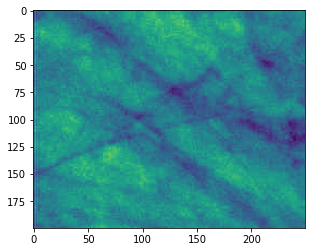

In [6]:
plt.imshow(a[1000:1200,0:250])

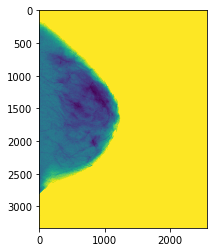

In [7]:
plt.imshow(a)

In [8]:
df.head()

,DummyID,filename,train
30806,75630429,FullRes/2/75630429_R_MLO_1.jpg,False
14805,76820102,FullRes/2/76820102_L_CC_1.jpg,False
19731,75239305,FullRes/2/75239305_R_CC_1.jpg,False
50342,75813271,FullRes/3/75813271_R_MLO_1.jpg,False
50871,3783618,FullRes/3/3783618_L_CC_1.jpg,False


In [9]:
df.iloc[4].filename

'FullRes/3/3783618_L_CC_1.jpg'

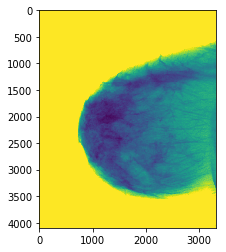

In [10]:
a = getImageData('75618445_L_CC_1.jpg')

plt.imshow(a)

### Dataset

#### DataLoaders

In [5]:
class Dataset_stored(torch.utils.data.Dataset):
  def __init__(self, dataList):
    
    
    self.data = dataList


    
  def __len__(self):
    
    return len(self.data)
    
  def __getitem__(self, index):
    
    data,label = self.data[index]
    
    return data,label


class Dataset(torch.utils.data.Dataset):
  def __init__(self, dataList):
    
    
    self.data = dataList


    
  def __len__(self):
    
    return len(self.data)
    
  def __getitem__(self, index):
    
    filename = self.data.iloc[index].filename.split("/")[-1]
    
    data = getImageData(filename)
    
    
    data = Image.fromarray(data)
    data = data.resize(imgSize)
    data = np.array(data)
    data = data/256.0 
    
    data = torchvision.transforms.ToTensor()(data)
    
    data = data.repeat((3,1,1))
    
    data = data.float()
    
    label = getRaceLabel(filename)
    
    return data,label

#### Testing

In [6]:
def loadData(df):
    
    dataList = []
    
    for i in tqdm(range(len(df))):


        filename = df.iloc[i].filename.split("/")[-1]

        data = getImageData(filename)

        data = Image.fromarray(data)
        data = data.resize((512,512))

        data = np.array(data)

        data = data/256.0 

        data = torchvision.transforms.ToTensor()(data)

        data = data.float()

        label = 1

        dataList.append((data,label))
        
    return(dataList)
    
    
    

### Testing pretrained FASTAI model

In [6]:
class fastAIModel(nn.Module):
    def __init__(self):
        super(fastAIModel, self).__init__()
        
    
        self.body =  Sequential(*list(resnet50().children())[:-2])
    
        
        self.head =     Sequential(
                            AdaptiveConcatPool2d(), Flatten(),
                            nn.BatchNorm1d(4096, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), 
                            nn.Dropout(p=0.25), 
                            nn.Linear(in_features=4096, out_features=512, bias=True), 
                            nn.ReLU(inplace = True),
                            nn.BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), 
                            nn.Dropout(p=0.5), 
                            nn.Linear(in_features=512, out_features=2, bias=True)
                        )
        
        
        self.total = nn.Sequential(self.body, self.head)
    
        
    def forward(self, x):
        
        
        x = self.total(x)
        

        return x
    

model = fastAIModel()

In [7]:
model.total.load_state_dict(torch.load('/home/santhosr/Documents/Birad/ProcessedData/models/model_resnet50_id10_acc833_loss386.pth')['model'])

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [8]:
df = pd.read_csv('/home/santhosr/Documents/Birad/FastAI/RaceClassification/withLargerDataset/DataFile10.csv')

trainDf = df[df.train==False]
testDf = df[df.train==True]

In [9]:
trainData = Dataset(trainDf)
testData = Dataset(testDf)

In [10]:
imgSize = (256,256)
device = 'cuda'

model.to(device)

test_batch_size = 100
test(model, testData, num_batches=1)

NameError: name 'logging' is not defined

### Model Architecture

In [23]:
lr=slice(5)

In [22]:
def lr_range(self, lr:Union[float,slice])->np.ndarray:
        "Build differential learning rates from `lr`."
        if not isinstance(lr,slice): return lr
        if lr.start: res = even_mults(lr.start, lr.stop, len(self.layer_groups))
        else: res = [lr.stop/10]*(len(self.layer_groups)-1) + [lr.stop]
        return np.array(res)

NameError: name 'Union' is not defined

In [24]:
[lr.stop/10]*(5-1) + [lr.stop]

[0.5, 0.5, 0.5, 0.5, 5]

In [25]:
def even_mults(start:float, stop:float, n:int)->np.ndarray:
    "Build log-stepped array from `start` to `stop` in `n` steps."
    mult = stop/start
    step = mult**(1/(n-1))
    return np.array([start*(step**i) for i in range(n)])

In [26]:
even_mults(5,10,5)

array([ 5.        ,  5.94603558,  7.07106781,  8.40896415, 10.        ])

In [34]:
model = torchvision.models.resnet50(pretrained=True)

model.conv1 = torch.nn.Conv2d(1, 64, 
            kernel_size=(7, 7), 
            stride=(2, 2), 
            padding=(3, 3), bias=False)

model.fc = nn.Linear(512,2)

In [9]:
# model = freezeLayers(model,9)

In [10]:
model.load_state_dict(torch.load("./models/resnet50_2_256_0.648_0.628"))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [41]:
for name, k in list(model.named_children()):
    print(name)
    print("____")


conv1
____
bn1
____
relu
____
maxpool
____
layer1
____
layer2
____
layer3
____
layer4
____
avgpool
____
fc
____


In [ ]:
optim.Adam([
    {'params': model.conv1.parameters(), 'lr': 1e-5},
    {'params': model.bn1.parameters()},
    {'params': model.relu.parameters()},
    {'params': model.maxpool.parameters()},
    {'params': model.layer1.parameters()},
    {'params': model.layer2.parameters()},
    {'params': model.layer3.parameters()},
    {'params': model.layer4.parameters()},
    {'params': model.avgpool.parameters()},
    {'params': model.fc.parameters(), 'lr': 1e-5}
], lr=1e-6, momentum=0.9)

In [33]:
for name, k in list(model.named_parameters())[:-1]:
    print(name)
    print("----")

conv1.weight
----
bn1.weight
----
bn1.bias
----
layer1.0.conv1.weight
----
layer1.0.bn1.weight
----
layer1.0.bn1.bias
----
layer1.0.conv2.weight
----
layer1.0.bn2.weight
----
layer1.0.bn2.bias
----
layer1.0.conv3.weight
----
layer1.0.bn3.weight
----
layer1.0.bn3.bias
----
layer1.0.downsample.0.weight
----
layer1.0.downsample.1.weight
----
layer1.0.downsample.1.bias
----
layer1.1.conv1.weight
----
layer1.1.bn1.weight
----
layer1.1.bn1.bias
----
layer1.1.conv2.weight
----
layer1.1.bn2.weight
----
layer1.1.bn2.bias
----
layer1.1.conv3.weight
----
layer1.1.bn3.weight
----
layer1.1.bn3.bias
----
layer1.2.conv1.weight
----
layer1.2.bn1.weight
----
layer1.2.bn1.bias
----
layer1.2.conv2.weight
----
layer1.2.bn2.weight
----
layer1.2.bn2.bias
----
layer1.2.conv3.weight
----
layer1.2.bn3.weight
----
layer1.2.bn3.bias
----
layer2.0.conv1.weight
----
layer2.0.bn1.weight
----
layer2.0.bn1.bias
----
layer2.0.conv2.weight
----
layer2.0.bn2.weight
----
layer2.0.bn2.bias
----
layer2.0.conv3.weight
----


In [30]:
list(model.named_parameters())[:-1]

[('conv1.weight', Parameter containing:
  tensor([[[[-0.0507,  0.0636, -0.0843,  ..., -0.1262,  0.0970, -0.0240],
            [-0.1133, -0.0640, -0.0900,  ...,  0.0143, -0.0863, -0.0955],
            [-0.0345,  0.0120, -0.0020,  ...,  0.1118, -0.0875, -0.0419],
            ...,
            [-0.1019, -0.1287,  0.1079,  ..., -0.0263,  0.0255,  0.0447],
            [ 0.1175,  0.1391,  0.0784,  ..., -0.0829, -0.1156,  0.0037],
            [ 0.1256,  0.1050,  0.0919,  ..., -0.1288, -0.0815,  0.0148]]],
  
  
          [[[-0.0014, -0.0955,  0.0093,  ...,  0.0086,  0.0166, -0.0735],
            [ 0.0963,  0.0931,  0.0901,  ...,  0.0623,  0.0371, -0.0077],
            [-0.0168, -0.0541,  0.1110,  ...,  0.0676,  0.0534,  0.0461],
            ...,
            [ 0.0446, -0.0656, -0.1405,  ..., -0.0801,  0.0676, -0.1376],
            [ 0.0832,  0.1005,  0.0154,  ...,  0.0104,  0.1290,  0.0195],
            [-0.0267, -0.1008, -0.1038,  ...,  0.0603, -0.0359, -0.0462]]],
  
  
          [[[ 0.0796, 

In [13]:
ct = 0
for name, child in model.named_children():
        ct += 1
        print(name)
        if ct < 12:
            for name2, params in child.named_parameters():
                print(params.requires_grad)

conv1
True
bn1
True
True
relu
maxpool
layer1
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
layer2
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
layer3
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
layer4
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
avgpool
fc
True
True


### Training

In [16]:
trainData = Dataset(df[df.train==False])
testData = Dataset(df[df.train==True])

In [17]:
batch_size = 60

trainLoader = torch.utils.data.DataLoader( trainData,
    batch_size = batch_size, shuffle = True)

testLoader = torch.utils.data.DataLoader( testData,
    batch_size = 100, shuffle = False)

In [18]:
device ='cuda'

criterion = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)

currentEpoch = 0
bestValLoss = 100
bestValAcc = 0 
modelNo = 0

In [19]:
model = freezeLayers(model,9)

In [20]:
train(model, trainLoader,1, optimizer, 0.001)

Train Epoch: 0 [0/30128 (0%)]	Loss: 0.754333


KeyboardInterrupt: 

In [21]:
loss,acc = test(model, testLoader, num_batches=1)

Epoch 0,val loss: 0.7290165424346924, val acc : 0.47


In [23]:
loss.item()

0.7290165424346924

In [ ]:
np.round